## Fig. 2 panel D umap
This notebook calculates 2D and 3D UMAP embeddings and generate plots

In [1]:
import os
import random
import sys
from datetime import datetime
from pathlib import Path
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
import umap
import umap.plot
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

plt.style.use('ggplot')
plt.rcParams['pdf.fonttype'] = 42

script_path = Path.cwd().parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent / "data"
sys.path.append(str(script_path))
from pyseus.plotting import plotly_umap as pu
from utils.label_processing import attach_annotations

save_path = Path.cwd() / "output"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### load data

In [2]:
# %store -r timestamp
timestamp = "2024-07-14"
print(f"Timestamp: {timestamp}") 

Timestamp: 2024-07-14


In [3]:
# define files to load
input_dir = Path.cwd().parent / "panel_C" / "output"
umap_table_path = input_dir / f"{timestamp}_umap_table.csv"
quants_path = input_dir / f"{timestamp}_quants.csv"

# load data
try:
    # load the file
    umap_table = pd.read_csv(umap_table_path, index_col=0)
except FileNotFoundError:
    print(f"File {umap_table_path} not found.\nPlease run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {umap_table_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

try:
    # load the file
    quants = pd.read_csv(quants_path, index_col=0)
except FileNotFoundError:
    print(f"File {quants_path} not found.\nPlease run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {quants_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### preprocessing

In [4]:
# scale the table for UMAP
scaled = pu.scale_table(matrix=quants, method='standard')

### PCA

In [5]:
# Perform PCA
pca = PCA(n_components=5)
pca.fit(scaled)

umap_table['PC_1'] = pca.transform(scaled)[:, 0]
umap_table['PC_2'] = pca.transform(scaled)[:, 1]

In [6]:
# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
variance_explained

array([0.22870587, 0.16835782, 0.06785963, 0.04982015, 0.03799735])

In [7]:
# generate 2D PCA plot
label_to_color = "consensus_graph_annnotation"  # **choose which annotation column to highlight here** , other choices: cluster_annotation, Protein-level_consensus_annotation

fig = pu.interaction_umap(
    umap_table,
    node_name="Gene_name_canonical", 
    cluster=label_to_color, opacity=0.35, unlabelled_color="#D0D3D4", unlabelled_opacity=0.1,
    pointsize=6, x="PC_1", y="PC_2",
    categorical=True,
)
fig.update_layout(width=1200, height=800)

fig.show()

# save the figure as an html file
save_path = os.path.join("output")
save_name = f"{timestamp}_PCA_2Dview.html"
pio.write_html(fig, file=os.path.join(save_path, save_name), auto_open=False)

### UMAP

In [8]:
# UMAP parameters
n_neighbors = 20
min_dist = 0.1
metric = 'euclidean'

# flip the umap coordinates (some times the UMAP algorithm flips the coordinates)
flip = True

# set the UMAP seed
UMAP_seed = 1234

In [9]:
# calculate 2D UMAP embeddings
fit = umap.UMAP(
    n_neighbors=n_neighbors, 
    min_dist=min_dist, 
    metric=metric, 
    random_state=UMAP_seed
)
u = fit.fit_transform(scaled)
umap_table['umap_1'] = u[:, 0] 
umap_table['umap_2'] = u[:, 1]

# flip the UMAP coordinates
if flip:
    max_x = max(umap_table["umap_1"])
    max_y = max(umap_table["umap_2"])
    umap_table["umap_1"] = max_x - umap_table["umap_1"]
    umap_table["umap_2"] = max_y - umap_table["umap_2"]


# calculate 3D UMAP embeddings
fit3D = umap.UMAP(
    n_neighbors=n_neighbors, 
    min_dist=min_dist, 
    metric=metric, 
    random_state=UMAP_seed, 
    n_components=3
)
u3D = fit3D.fit_transform(scaled)
# add the UMAP coordinates to the table
umap_table['3D_umap_1'] = u3D[:, 0] 
umap_table['3D_umap_2'] = u3D[:, 1]
umap_table['3D_umap_3'] = u3D[:, 2]

### save UMAP embeddings

In [10]:
# save umap embedding to csv file
save_name = f"{timestamp}_UMAP_embeddings_seed={UMAP_seed}.csv"
umap_table.to_csv(os.path.join(save_path, save_name), index=False)

In [11]:
# save scaled quants to csv file
save_name = f"{timestamp}_scaled_quants.csv"
umap_table.iloc[:, 8:68] = scaled # this line might need to be adjusted depending on the number of columns in the quants file
umap_table.to_csv(os.path.join(save_path, save_name), index=False)

# save 0-1 scaled quants to csv file
def normalize_rowwise(df):
    row_sums = df.sum(axis=1)
    normalized_df = df.div(row_sums, axis=0)
    return normalized_df
save_name = f"{timestamp}_01_scaled_quants.csv"
data = umap_table.iloc[:, 8:69].copy()
data[data<0] = 0
umap_table.iloc[:, 8:69] = normalize_rowwise(data)
umap_table.to_csv(os.path.join(save_path, save_name), index=False)

### update annotation 
remove `cluster_annotation`, `Graph-based_localization_annotation` and `consensus_graph_annnotation`  
replace with that from 2023-10-21-imp5-for-figures

In [12]:
# attach canonical gene names
gene_name_csv = data_path / "labels" / "2023-10-21-imp5-for-figures_graph-based_annotations.csv"

lookup_table = pd.read_csv(gene_name_csv)
to_df = umap_table.copy()
list_of_cols_to_add = reversed(["Graph-based_localization_annotation"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c, from_on="Majority protein IDs", to_on="Majority protein IDs")
    umap_table["[all_IPs] Graph-based_localization_annotation"] = new_col_data

lookup_table = pd.read_csv(gene_name_csv)
to_df = umap_table.copy()
list_of_cols_to_add = reversed(["consensus_graph_annnotation"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c, from_on="Majority protein IDs", to_on="Majority protein IDs")
    umap_table["[all_IPs] consensus_graph_annnotation"] = new_col_data

In [13]:
# construct 14-3-3 vs other column
umap_table["[all_IPs] 14-3-3_graph"] = umap_table["[all_IPs] Graph-based_localization_annotation"].apply(lambda x: "14-3-3_scaffold" if x == "14-3-3_scaffold" else None)
umap_table["[all_IPs] 14-3-3_consensus"] = umap_table["[all_IPs] consensus_graph_annnotation"].apply(lambda x: "14-3-3_scaffold" if x == "14-3-3_scaffold" else None)

In [14]:
umap_table["[all_IPs] 14-3-3_consensus"].value_counts()

14-3-3_scaffold    130
Name: [all_IPs] 14-3-3_consensus, dtype: int64

### generate UMAP plots

In [15]:
# generate 2D UMAP plot
label_to_color = "[all_IPs] consensus_graph_annnotation"  # **choose which annotation column to highlight here** , other choices: cluster_annotation, Protein-level_consensus_annotation

fig = pu.interaction_umap(
    umap_table,
    node_name="Gene_name_canonical", 
    cluster=label_to_color, opacity=0.5, unlabelled_color="#D0D3D4", unlabelled_opacity=0.2,
    pointsize=6, x="umap_1", y="umap_2",
    categorical=True
)
fig.update_layout(width=1200, height=800)

fig.show()

# save the figure as an html file
save_path = os.path.join("output")
save_name = f"{timestamp}_UMAP_2Dview_ported_consensus_annot.html"
pio.write_html(fig, file=os.path.join(save_path, save_name), auto_open=False)

In [16]:
# generate 2D UMAP plot
label_to_color = "[all_IPs] 14-3-3_consensus"  # **choose which annotation column to highlight here** , other choices: cluster_annotation, Protein-level_consensus_annotation

fig = pu.interaction_umap(
    umap_table,
    node_name="Gene_name_canonical", 
    cluster=label_to_color, opacity=0.5, unlabelled_color="#D0D3D4", unlabelled_opacity=0.2,
    pointsize=6, x="umap_1", y="umap_2",
    categorical=True, custom_colors = ["#ff0000", "#e1e3e1"]
)
fig.update_layout(width=1200, height=800)

fig.show()

# save the figure as an html file
save_path = os.path.join("output")
save_name = f"{timestamp}_UMAP_2Dview_ported_consensus_annot.html"
pio.write_html(fig, file=os.path.join(save_path, save_name), auto_open=False)

### 14-3-3 cluster analysis

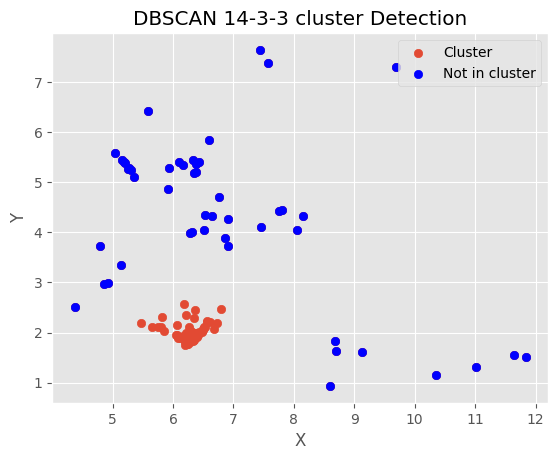

In [19]:
# produce a list of clustering patterns of 14-3-3 scaffold proteins 
umap_table_1433 = umap_table[umap_table["[all_IPs] 14-3-3_consensus"] == "14-3-3_scaffold"]

points = umap_table_1433[["umap_1", "umap_2"]].values

# DBSCAN parameters
epsilon = 0.4  # Maximum distance between points to be considered as neighbors
min_samples = 10  # Minimum number of points to form a cluster

# Apply DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points)
labels = db.labels_

umap_table_1433["DBSCAN_cluster"] = ["in 14-3-3 cluster" if i != -1 else "not in 14-3-3 cluster" for i in labels ]

# Identify outliers (points labeled as -1)
outliers = points[labels == -1]

# Plot the points and highlight the outliers
plt.scatter(points[:, 0], points[:, 1], label='Cluster')
plt.scatter(outliers[:, 0], outliers[:, 1], color='blue', label='Not in cluster')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN 14-3-3 cluster Detection')
plt.show()

### write 14-3-3 dataframe to file

In [34]:
umap_table_1433_csv = umap_table_1433.copy()[["Majority protein IDs", "Gene names", "Graph-based_localization_annotation", "consensus_graph_annnotation",
                                             "[all_IPs] Graph-based_localization_annotation", "[all_IPs] consensus_graph_annnotation", "DBSCAN_cluster"]]

# rename columns
umap_table_1433_csv.rename(columns={"DBSCAN_cluster": "[without 14-3-3 IP] in UMAP 14-3-3 cluster",
                                    "Graph-based_localization_annotation": "[without 14-3-3 IP] Graph-based_localization_annotation",
                                    "consensus_graph_annnotation": "[without 14-3-3 IP] consensus_graph_annnotation",
                                    }, inplace=True)

# save to file
save_name = f"{timestamp}_remove_14-3-3_IP.csv"
umap_table_1433_csv.to_csv(os.path.join(save_path, save_name), index=False)

In [31]:
umap_table_1433_csv["[without 14-3-3 IP] in 14-3-3 cluster"].value_counts()

in 14-3-3 cluster        81
not in 14-3-3 cluster    49
Name: [without 14-3-3 IP] in 14-3-3 cluster, dtype: int64

In [32]:
umap_table_1433_csv["[without 14-3-3 IP] consensus_graph_annnotation"].value_counts()

14-3-3_scaffold       97
cytosol               15
nucleus                5
unclassified           3
plasma_membrane        3
translation            2
actin_cytoskeleton     2
lysosome               1
stress_granule         1
ER                     1
Name: [without 14-3-3 IP] consensus_graph_annnotation, dtype: int64